In [375]:
import pandas as pd
import numpy as np
import chardet
from collections import defaultdict

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as ply

## Load and Clean User Data

In [376]:
# Read a the file in binary mode
with open('takehome_users.csv', 'rb') as f:
    encoding_info = chardet.detect(f.read())

print(f"Detected encoding: {encoding_info['encoding']} (Confidence: {encoding_info['confidence']:.2f})")

# Loading data from csv with correct encoding
users_df = pd.read_csv('takehome_users.csv', parse_dates = ['creation_time'], index_col = 'object_id', encoding = encoding) 

Detected encoding: ISO-8859-1 (Confidence: 0.73)


In [378]:
# Convert timestamps & boolean columns
datetime_columns = ['creation_time', 'last_session_creation_time']
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'], unit = 's')
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit = 's')

bool_columns = ["opted_in_to_mailing_list", "enabled_for_marketing_drip"]
users_df[bool_columns] = users_df[bool_columns].astype(bool)

### Treating missing values

In [379]:
users_df.isna().sum()

creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [355]:
try:
    print(users_df.loc[0])
except:
    print('There is no object_id == 0')

There is no object_id == 0


In [356]:
# Impute NaN in invited_by_user_id by 0
users_df['invited_by_user_id'] = users_df['invited_by_user_id'].fillna(0).astype('int')

# Impute NaT values for last_session_creation_time by '1970-01-01'
users_df['last_session_creation_time'] = users_df['last_session_creation_time'].fillna(pd.Timestamp("1970-01-01"))

In [357]:
users_df.isna().sum()

creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

## Load and Analyse Login Data

In [358]:
logins_df = pd.read_csv('takehome_user_engagement.csv', parse_dates = ['time_stamp'], encoding = encoding_info['encoding'])

print(f'Missing values in the Login Data:\n{logins_df.isna().sum()}')
print(f'\nThe number of unique users: {logins_df['user_id'].nunique()}')
print('\n')
print(logins_df.info())
print('\n')
print(logins_df.describe())

Missing values in the Login Data:
time_stamp    0
user_id       0
visited       0
dtype: int64

The number of unique users: 8823


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB
None


                          time_stamp        user_id   visited
count                         207917  207917.000000  207917.0
mean   2013-10-30 05:06:45.648763648    5913.314197       1.0
min              2012-05-31 08:20:06       1.000000       1.0
25%              2013-07-16 20:17:21    3087.000000       1.0
50%              2013-12-03 06:38:34    5682.000000       1.0
75%              2014-03-13 08:00:24    8944.000000       1.0
max             

In [359]:
# Assessing whether a user is adopeted or not
logins_df = logins_df.set_index('time_stamp')
adopted_users = defaultdict(bool)
check = []

for user in logins_df['user_id'].unique():
    user_activity = pd.DataFrame(logins_df[logins_df['user_id'] == user].resample('D').size(), columns = ['logins'])
    check.append(max(user_activity['logins']))
    user_activity['MS_7days'] = user_activity['logins'].rolling(7, min_periods = 1).sum()
    adopted_users[user] = (True if max(user_activity['MS_7days']) >= 3 else False)

# To check that there were no two or more records for the same user_id on a single day
print("Are there any users with two or more records on the same day?", (True if max(check) > 1 else False))

Are there any users with two or more records on the same day? False


In [360]:
# Converting the new feature (adopted_user) into DataFrame
adopted_users_df = pd.DataFrame.from_dict(adopted_users, orient = 'index', columns = ['adopted_user'])
adopted_users_df.index.name = 'user_id'

# Enriching the original user data by the target variable
users_df = pd.merge(users_df, adopted_users_df, left_on = 'object_id', right_on = 'user_id', how = 'outer')

print('The number of users in the users dataset:', len(users_df))
print('The number of users from the login dataset:', logins_df['user_id'].nunique())

The number of users in the users dataset: 12000
The number of users from the login dataset: 8823


In [361]:
users_df.loc[users_df['last_session_creation_time'] == '1970-01-01 00:00:00', 'adopted_user'].unique()

array([nan], dtype=object)

We can see that we have more records in the original user information dataset than we have records about adopted users (12,000 vs. 8,823). Furthermore, all records (and only them) that initially had NaN values in ‘last_session_creation_time’ (I imputed them with ‘1970-01-01 00:00:00’) do not have any login information in ‘takehome_user_engagement.csv’.

This means that there is no reason to keep these records because we can not use them for modeling — we do not know whether they are adopted users or not (maybe their login records were just missed or not included, OR maybe they really did not log in at all—we simply do not know and cannot assume anything about this).

In [362]:
users_df = users_df.dropna()
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8823 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               8823 non-null   datetime64[ns]
 1   name                        8823 non-null   object        
 2   email                       8823 non-null   object        
 3   creation_source             8823 non-null   object        
 4   last_session_creation_time  8823 non-null   datetime64[ns]
 5   opted_in_to_mailing_list    8823 non-null   bool          
 6   enabled_for_marketing_drip  8823 non-null   bool          
 7   org_id                      8823 non-null   int64         
 8   invited_by_user_id          8823 non-null   int64         
 9   adopted_user                8823 non-null   object        
dtypes: bool(2), datetime64[ns](2), int64(2), object(4)
memory usage: 637.6+ KB


## Preparing dataset for the model

In [363]:
users_df.head(5)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,True,False,11,10803,False
1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,False,False,1,316,True
2,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,False,False,94,1525,False
3,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,False,False,1,5151,False
4,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,False,False,193,5240,False


I will also drop 'name' and 'email' columns to avoid overfitting by memorizing exact personal information. 

I will keep 'creation_time' and 'last_session_creation_time' but convert them to integer format (as the number of days from 1970-01-01) to make them sutable for modelling and avoid overfitting due to precise timestemp.

I also consider that 'last_session_creation_time' can be the most influential factor but it might be too impractical to use it because it may be too late to predict the user churn when a user has not logged in for some time. However, I will test two approaches: including 'last_session_creation_time' as factor and excluding it.

In [364]:
model_df = users_df.reset_index(drop = True)
model_df = model_df.drop(columns = ['name', 'email'])

model_df['creation_time'] = (model_df['creation_time'] - pd.Timestamp('1970-01-01')) // pd.Timedelta(days = 1)
model_df['last_session_creation_time'] = (model_df['last_session_creation_time'] - pd.Timestamp('1970-01-01')) // pd.Timedelta(days = 1)

model_df['adopted_user'] = model_df['adopted_user'].astype('bool')

model_df.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,16182,GUEST_INVITE,16182,True,False,11,10803,False
1,16024,ORG_INVITE,16160,False,False,1,316,True
2,15783,ORG_INVITE,15783,False,False,94,1525,False
3,15846,GUEST_INVITE,15847,False,False,1,5151,False
4,15722,GUEST_INVITE,15727,False,False,193,5240,False


In [365]:
print('Number of unique orgaisations IDs:', users_df['org_id'].nunique())
print('Number of unique invited by user IDs:', users_df['invited_by_user_id'].nunique())
print('Number of unique creation sources:', users_df['creation_source'].nunique())

Number of unique orgaisations IDs: 417
Number of unique invited by user IDs: 2230
Number of unique creation sources: 5


The 'creation_source' column contains justs few unique value (5) and can be OneHotEncoded. However, two other columns ('org_id' and 'invited_by_user_id') contain too many unique values for OneHotEncoding, so I will use Frequency Encoding in the Pipeline to prevent data leakage.

In [366]:
# Copy for correlation analysis (without dummies)
correlation_df = model_df
cols = list(correlation_df.columns)
cols.remove('adopted_user')
cols.append('adopted_user')
model_df = correlation_df[cols]

# OneHotEncoding the 'creation_source; column
model_df = pd.get_dummies(model_df, columns = ['creation_source'], drop_first = True)

# Rearrange columns for convenience 
cols = list(model_df.columns)
cols.remove('adopted_user')
cols.append('adopted_user')
model_df = model_df[cols]

In [367]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8823 entries, 0 to 8822
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   creation_time                       8823 non-null   int64
 1   last_session_creation_time          8823 non-null   int64
 2   opted_in_to_mailing_list            8823 non-null   bool 
 3   enabled_for_marketing_drip          8823 non-null   bool 
 4   org_id                              8823 non-null   int64
 5   invited_by_user_id                  8823 non-null   int64
 6   creation_source_ORG_INVITE          8823 non-null   bool 
 7   creation_source_PERSONAL_PROJECTS   8823 non-null   bool 
 8   creation_source_SIGNUP              8823 non-null   bool 
 9   creation_source_SIGNUP_GOOGLE_AUTH  8823 non-null   bool 
 10  adopted_user                        8823 non-null   bool 
dtypes: bool(7), int64(4)
memory usage: 336.2 KB


## Correlation analysis

In [368]:
my_encoder = LabelEncoder()
correlation_df['creation_source'] = my_encoder.fit_transform(correlation_df['creation_source'].astype('category'))
correlation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8823 entries, 0 to 8822
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   creation_time               8823 non-null   int64
 1   creation_source             8823 non-null   int64
 2   last_session_creation_time  8823 non-null   int64
 3   opted_in_to_mailing_list    8823 non-null   bool 
 4   enabled_for_marketing_drip  8823 non-null   bool 
 5   org_id                      8823 non-null   int64
 6   invited_by_user_id          8823 non-null   int64
 7   adopted_user                8823 non-null   bool 
dtypes: bool(3), int64(5)
memory usage: 370.6 KB


<Axes: >

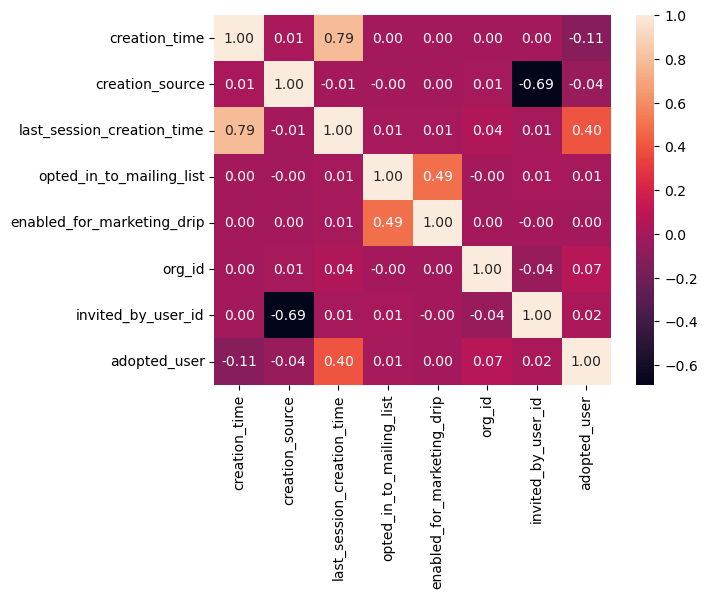

In [369]:
# Plot heatmap for correlation matrix
heatmap = correlation_df.corr()
sns.heatmap(data = heatmap, annot = True, fmt = '.2f')

We observe that the most influential factors are:
-	The time of the last login (though it may be a post-hoc factor)
-	The sign-up date
-	The organization

## Modelling

In [370]:
# Separate factors and target variable
X = model_df.iloc[:, :-1]
y = model_df.iloc[:, -1]

In [371]:
# Split onto train and test datasets
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.2, random_state = 1812)

__NOTE:__ We do not need to split the data into training and testing datasets because our goal is to identify the most influential factors rather than to evaluate a model.

In [372]:
# Define my transformer to use frequency encoding without data leakage
from sklearn.base import BaseEstimator, TransformerMixin

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    # Transformer for frequency encoding of a categorical column

    def __init__(self, column):
        self.column = column
        self.freq_mapping = None

    def fit(self, X, y=None):
        # Computing frequencies based only on training data
        self.freq_mapping = X[self.column].value_counts().to_dict()
        return self

    def transform(self, X):
        # Frequency encoding
        X_copy = X.copy()
        X_copy[self.column] = X_copy[self.column].map(self.freq_mapping).fillna(0)
        return X_copy

In [373]:
# Define two models to identify independently the most influential factors: Random Forest and Gradient Boosting
# I will use both model to get 'two independent decisions'
models = {'Random Forest': RandomForestClassifier(min_samples_leaf = 5, random_state = 1812, n_jobs = -1),
          'Gradient Boosting': GradientBoostingClassifier(max_leaf_nodes = 15, random_state = 1812)}

# Hyperparameters fro each model
param_grids = {'Random Forest': {'classifier__n_estimators': [10, 20, 50, 100]},
               'Gradient Boosting': {'classifier__learning_rate': [0.1, 0.01, 0.001]}}

# Define folds for cross-validation
cv = KFold(n_splits = 4, shuffle = True, random_state = 1812)

# Use cross validation in cycle for each model
results = []
for name, model in models.items():
    # Pipeline to apply frequence encoding for two factors - 'org_id' and 'invited_by_user_id' 
    pipeline = Pipeline([
        ('freq_encoder_org', FrequencyEncoder(column = 'org_id')),
        ('freq_encoder_inv', FrequencyEncoder(column = 'invited_by_user_id')),
        ('classifier', model)])
    
    # Grid searche for the best hyperparameters 
    grid_search = GridSearchCV(
        estimator = pipeline,
        param_grid = param_grids[name],
        return_train_score = True,
        cv = cv).fit(X, y)

    # Save results
    result = {'model': name, 
              'cv_results': pd.DataFrame(grid_search.cv_results_),
              'feature_importance': grid_search.best_estimator_.named_steps['classifier'].feature_importances_
              }
    results.append(result)

In [374]:
# Print the most influencial factors for each model
for i in range(2):
    feature_importance = defaultdict(float)
    for feature, importance in zip(tmp_df.columns[:-1], results[i]['feature_importance']):
        feature_importance[feature] = importance

    print('Model name:', results[i]['model'])
    print(pd.DataFrame.from_dict(feature_importance, orient = 'index', columns = ['Importance']).sort_values('Importance', ascending = False))
    print('')

Model name: Random Forest
                            Importance
creation_source               0.765567
creation_time                 0.181500
enabled_for_marketing_drip    0.030312
org_id                        0.010391
invited_by_user_id            0.003070
last_session_creation_time    0.002243
opted_in_to_mailing_list      0.002142

Model name: Gradient Boosting
                            Importance
creation_source               0.580508
creation_time                 0.417320
enabled_for_marketing_drip    0.001314
opted_in_to_mailing_list      0.000276
last_session_creation_time    0.000132
org_id                        0.000100
invited_by_user_id            0.000000



We see both models don't pay too much attention to the 'last_session_creation_time', so I will not try training models excluding this factor.

The most important factors predicting future user adoption are:
- Creation Source 
- Creation Time